# Тестирование и визуализация VAE и латентных датасетов

In [1]:
%matplotlib inline

import autoroot
import autorootcwd

import sys
sys.path.append("sbervae")

import torch

import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import DataLoader

from dit_updates.vae.adapters.base import VAEAdapter
from dit_updates.vae.adapters.wan_official import WANOfficialAdapter
from dit_updates.vae.adapters.wan_mil import WANYuv2RgbAdapter
from dit_updates.data.imagenet import create_imagenet_dataset
from dit_updates.data.transforms import DiTCenterCrop
from dit_updates.data.latent_datasets import LatentsShardDataset

/home/akhtyamov/miniconda/envs/sbervae_py310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/akhtyamov/miniconda/envs/sbervae_py310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/akhtyamov/projects/DiT-updates/sbervae/lib/losses/lpips/lpips.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unp

loaded pretrained LPIPS loss from sgm/modules/autoencoding/lpips/loss/vgg.pth


Важно: устновить правильный девайс!

In [2]:
DEVICE = "cuda:4"

In [3]:
def probe_vae(model: VAEAdapter, dataset_path: str, normalize: bool, device: str, title: str | None = None):
    preprocessor = model.create_preprocessor()

    transforms = T.Compose([
        DiTCenterCrop(256),
        T.ToTensor(),
        preprocessor
    ])
    transforms_original = T.Compose([
        DiTCenterCrop(256),
        T.ToTensor(),
    ])

    dataset = create_imagenet_dataset(
        image_dir=dataset_path,
        transform=transforms
    )
    dataset_original = create_imagenet_dataset(
        image_dir=dataset_path,
        transform=transforms_original
    )

    dataloader = DataLoader(dataset, 
                                 batch_size=2, 
                                 shuffle=False, 
                                 num_workers=8, 
                                 pin_memory=True)
    dataloader_original = DataLoader(dataset_original, 
                                 batch_size=2, 
                                 shuffle=False, 
                                 num_workers=8, 
                                 pin_memory=True)

    images, _ = next(iter(dataloader))
    images_original, _ = next(iter(dataloader_original))

    images = images.to(device)
    latents, _ = model.encode(images, normalize=normalize, sample=True)
    images_rec, _ = model.decode(latents, denormalize=normalize)
    images_rec = preprocessor.inverse(images_rec)

    to_pil = T.ToPILImage()
    images_original = [to_pil(image) for image in images_original[:2]]
    images_rec = [to_pil(image) for image in images_rec[:2]]

    # Some random image from the original dataset
    sample_idx = 5959
    image_random = dataset_original[sample_idx][0].to(device)
    images_original.append(to_pil(image_random))
    image_random = dataset[sample_idx][0].to(device)
    image_random_latent, _ = model.encode(image_random, normalize=normalize, sample=True)
    image_random_rec, _ = model.decode(image_random_latent, denormalize=normalize)
    image_random_rec = preprocessor.inverse(image_random_rec)
    images_rec.append(to_pil(image_random_rec))
    
    fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    if title:
        plt.suptitle(title)
    for i in range(len(images_original)):
        axes[i, 0].imshow(images_original[i])
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")
        axes[i, 1].imshow(images_rec[i])
        axes[i, 1].set_title("Reconstructed")
        axes[i, 1].axis("off")
    plt.tight_layout()
    plt.show()


def probe_latent_dataset(model: VAEAdapter, 
                         image_dataset_path: str, 
                         latent_dataset_path: str,
                         normalize: bool,
                         device: str,
                         title: str | None = None):
    preprocessor = model.create_preprocessor()

    transforms_original = T.Compose([
        DiTCenterCrop(256),
        T.ToTensor(),
    ])
    dataset_original = create_imagenet_dataset(
        image_dir=image_dataset_path,
        transform=transforms_original
    )
    dataloader_original = DataLoader(dataset_original, 
                                 batch_size=2, 
                                 shuffle=False, 
                                 num_workers=8, 
                                 pin_memory=True)
    dataset = LatentsShardDataset(latent_dataset_path, 
                                  split="train", 
                                  latent_normalizer=model.latent_normalizer.numpy(),
                                  sample=True)
    dataloader = DataLoader(dataset, 
                           batch_size=2, 
                           shuffle=False, 
                           num_workers=8, 
                           pin_memory=True)

    to_pil = T.ToPILImage()

    images, _ = next(iter(dataloader_original))
    images_original = [to_pil(image) for image in images]
    
    latents, _ = next(iter(dataloader))
    images_rec, _ = model.decode(latents.to(device), denormalize=normalize)
    images_rec = preprocessor.inverse(images_rec)
    images_rec = [to_pil(image) for image in images_rec]

    sample_idx = 5959
    image_random = dataset_original[sample_idx][0].to(device)
    images_original.append(to_pil(image_random))
    latent_random = dataset[sample_idx][0].to(device)
    image_random_rec, _ = model.decode(latent_random, denormalize=normalize)
    image_random_rec = preprocessor.inverse(image_random_rec)
    images_rec.append(to_pil(image_random_rec))

    fig, axes = plt.subplots(3, 2, figsize=(8, 8))
    if title:
        plt.suptitle(title)
    for i in range(len(images_original)):
        axes[i, 0].imshow(images_original[i])
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")
        axes[i, 1].imshow(images_rec[i])
        axes[i, 1].set_title("Reconstructed")
        axes[i, 1].axis("off")
    plt.tight_layout()
    plt.show()

### Wan 2.1 Official

In [4]:
model = WANOfficialAdapter(name="wan_2.1_official",
                           checkpoint="Wan2.1-T2V-14B/Wan2.1_VAE.pth",
                           latent_norm_type="scale",
                           latent_stats="imagenet2012",
                           device=DEVICE)

/home/akhtyamov/projects/DiT-updates/dit_updates/vae/models/wan.py:626: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(pretrained_path, map_location=device), assig

/home/akhtyamov/projects/DiT-updates/dit_updates/vae/adapters/wan_official.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(dtype=self._dtype):
/home/akhtyamov/projects/DiT-updates/dit_updates/vae/adapters/wan_official.py:315: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(dtype=self._dtype):


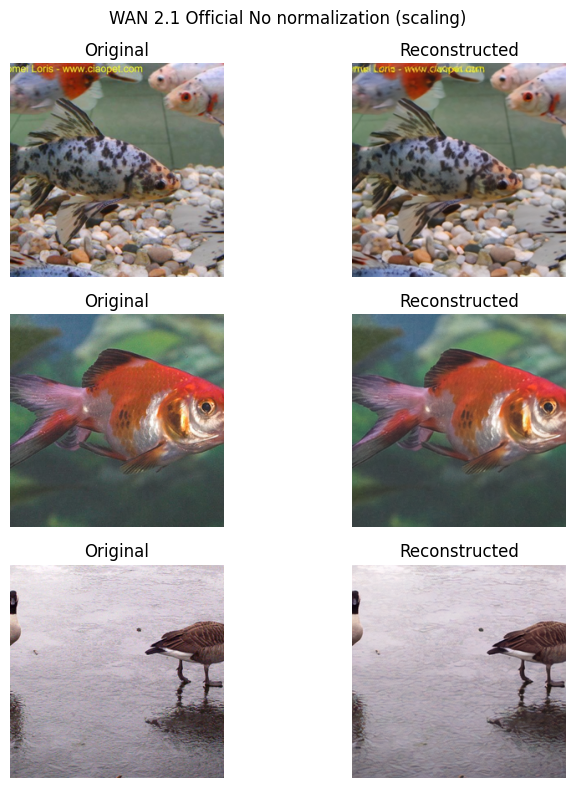

In [5]:
probe_vae(model=model, 
          dataset_path="ImageNet2012_200/train", 
          normalize=False, 
          device=DEVICE, 
          title="WAN 2.1 Official No normalization (scaling)")

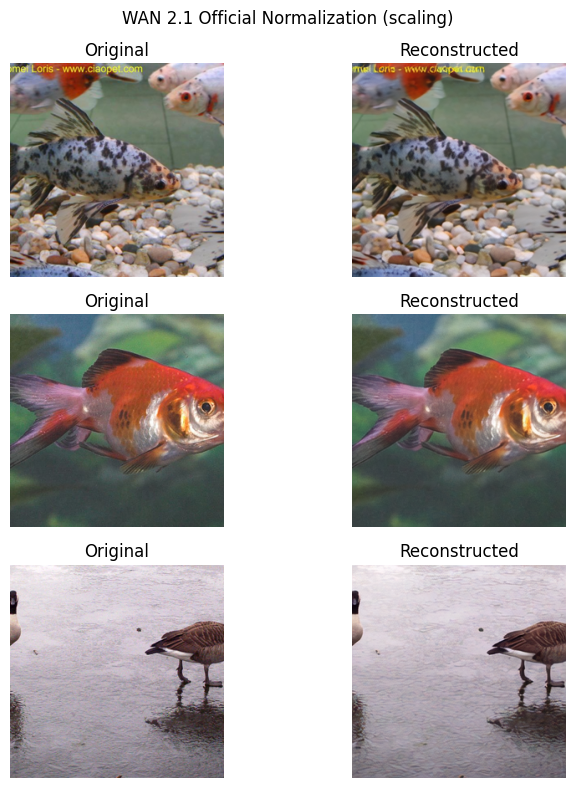

In [6]:
probe_vae(model=model, 
          dataset_path="ImageNet2012_200/train", 
          normalize=True, 
          device=DEVICE, 
          title="WAN 2.1 Official Normalization (scaling)")

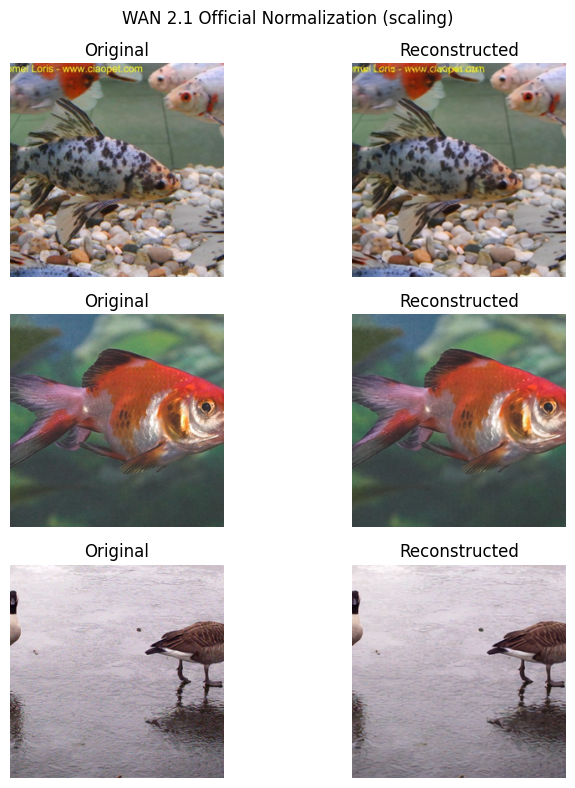

In [7]:
probe_latent_dataset(model, 
                     image_dataset_path="ImageNet2012_200/train", 
                     latent_dataset_path="/lvmdata/shared/SberVAE/data/latents/ImageNet2012_200__wan_2.1_official__resolution_256/", 
                     normalize=True, 
                     device=DEVICE,
                     title="WAN 2.1 Official Normalization (scaling)")


In [8]:
del model

### Wan internal YUV2RGB

In [4]:
model = WANYuv2RgbAdapter(latent_norm_type="none",
                          latent_stats=None,
                          device=DEVICE)

/home/akhtyamov/projects/DiT-updates/sbervae/lib/models/wan_vae/wan_vae.py:873: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(pretrained_path, map_location=device

In [ ]:
probe_vae(model=model, 
          dataset_path="ImageNet2012_200/train", 
          normalize=False, 
          device=DEVICE, 
          title="WAN 2.1 Official No normalization (scaling)")